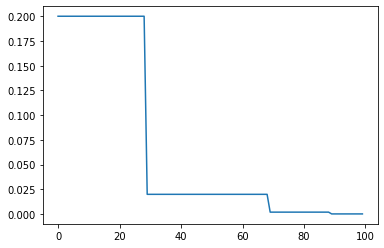

In [26]:
from dataclasses import dataclass
import torch

@dataclass(init=True)
class Flags():
    base_learning_rate: float
    train_batch_size:int

global FLAGS
FLAGS = Flags(base_learning_rate=0.1, train_batch_size=512)

global LR_SCHEDULE
LR_SCHEDULE = [(1.0, 0), (0.1, 30), (0.01, 70), (0.001, 90), (.0001, 120)]

def lr_schedule(current_epoch):
    """Computes learning rate schedule."""
    scaled_lr = FLAGS.base_learning_rate * (FLAGS.train_batch_size / 256.0)
    decay_rate = (
            scaled_lr * LR_SCHEDULE[0][0] * current_epoch / LR_SCHEDULE[0][1]
        ) 
    # print(decay_rate)
    for mult, start_epoch in LR_SCHEDULE:
        decay_rate = torch.where(current_epoch < start_epoch, decay_rate, scaled_lr * mult)
    return decay_rate


epochs = torch.arange(1,101)
lrs = []

for e in epochs:
    lrs.append(lr_schedule(e).item())

import matplotlib.pyplot as plt
plt.plot(lrs)

In [25]:
current_epoch=torch.tensor([1], dtype=torch.int8)
scaled_lr = FLAGS.base_learning_rate * (FLAGS.train_batch_size / 256.0)
decay_rate = (
        scaled_lr * LR_SCHEDULE[0][0] * current_epoch / LR_SCHEDULE[0][1]
    ) 
print(decay_rate)
for mult, start_epoch in LR_SCHEDULE:
        decay_rate = torch.where(current_epoch < start_epoch, decay_rate, scaled_lr * mult)
print(decay_rate)

tensor([inf])
tensor([1.6000])


In [18]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, _LRScheduler
from torch.optim import AdamW
import math
from rigl_torch.datasets import get_dataloaders
from rigl_torch.optim import StepLrWithLinearWarmUp


In [1]:
from rigl_torch.datasets import get_dataloaders
from omegaconf import DictConfig
from rigl_torch.models import ModelFactory
import hydra

with hydra.initialize(config_path="../configs"):
    cfg = hydra.compose(config_name="config.yaml", overrides=["dataset=cifar10", "model=wide_resnet22", "compute.distributed=False"])
cfg

net = ModelFactory.load_model("wide_resnet22", "cifar10")

INFO:/home/condensed-sparsity/src/rigl_torch/models/model_factory.py:Registering mnist for mnist dataset to ModelFactory...
INFO:/home/condensed-sparsity/src/rigl_torch/models/model_factory.py:Registering resnet18 for cifar10 dataset to ModelFactory...
INFO:/home/condensed-sparsity/src/rigl_torch/models/model_factory.py:Registering wide_resnet22 for cifar10 dataset to ModelFactory...
INFO:/home/condensed-sparsity/src/rigl_torch/models/model_factory.py:Registering cond_net for mnist dataset to ModelFactory...
INFO:/home/condensed-sparsity/src/rigl_torch/models/model_factory.py:Registering wide_resnet22 for imagenet dataset to ModelFactory...
INFO:/home/condensed-sparsity/src/rigl_torch/models/model_factory.py:Registering resnet18 for imagenet dataset to ModelFactory...
INFO:/home/condensed-sparsity/src/rigl_torch/models/model_factory.py:Registering resnet50 for imagenet dataset to ModelFactory...
/tmp/ipykernel_153204/82332062.py:6: UserWarning: 
The version_base parameter is not specif

In [4]:
import torchvision
cifar = torchvision.datasets.CIFAR10(root="../data/", download=True)

Files already downloaded and verified


In [21]:
len(cifar)

50000

In [22]:
import torch
import torch.nn.functional as F
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel

def main(rank, cfg):
    cifar = torchvision.datasets.CIFAR10(root="../data/", download=True)
    device = torch.device(f"cuda:{rank}")
    train_sampler = torch.utils.data.distributed.DistributedSampler(
        cifar, drop_last=True
    )
    train_loader = torch.utils.data.DataLoader(
        cifar,
        sampler=train_sampler,
        batch_size=128,
        shuffle=True,
    )
    print(f"Num samples in rank {rank}: {len(train_loader)*256}") 

    


mp.spawn(
    main,
    args=(cfg,),
    nprocs=2,
)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/conda/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/conda/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'main' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/opt/conda/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/opt/conda/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'main' on <module '__main__' (built-in)>


KeyboardInterrupt: 

In [5]:
train, test = get_dataloaders(cfg)

Files already downloaded and verified


In [6]:
cfg.training.batch_size

32

In [7]:
len(train)

1562

In [8]:
len(train.dataset)

50000

In [9]:
len(train.dataset) / cfg.training.batch_size

1562.5

In [10]:
for imgs,labels in train:
    break

In [2]:
import torch
from rigl_torch.optim import get_lr_scheduler, get_optimizer
optim = get_optimizer(cfg, net, None)
lr_scheduler = get_lr_scheduler(cfg, optim, None)



# adamw1 = AdamW(net.parameters(), lr=0.001)
# adamw2 = AdamW(net.parameters(), lr=0.001)
# linear_step = torch.optim.lr_scheduler.StepLR(adamw2, step_size=30000, gamma=0.2)
# cawr = CosineAnnealingWarmRestarts(optimizer=adamw1, T_0=20, T_mult=2)
# ca = CosineAnnealingLR(optimizer=adamw2, T_max=T_max)
# adamw3 = AdamW(net.parameters(), lr=0.001)
# test= CosineAnnealingWithLinearWarmUp(optimizer=adamw3, T_max=T_max, warm_up_steps=50, lr=0.001)

In [12]:
# lr_scheduler.get_last_lr()

In [13]:
# lr_scheduler.step_size

In [3]:
%matplotlib inline
lrs=[]
step_lrs=[]
# from torch.optim.lr_scheduler import StepLR
# step_scheduler = StepLR(optim, step_size=30, gamma=0.1)
for epoch in range(0,100):
    # lr = [group["lr"] for group in optim.param_groups][0]
    lr=lr_scheduler.get_last_lr()[0]
    lrs.append(lr)
    lr_scheduler.step()
    # lr = [group["lr"] for group in optim.param_groups][0]
    # step_lrs.append(lr)
    # step_scheduler.step()

# for x in range(T_max):
#     lr1 = cawr.get_last_lr()
#     warm_restart_lrs.append(lr1)
#     cawr.step()
#     lr2 = linear_step.get_last_lr()
#     linear_step_lrs.append(lr2)
#     linear_step.step()
    # combined.append(lr1[0] * lr2[0]*1000)
    # lr3 = test.get_last_lr()
    # linear_warmup.append(lr3)
    # test.step()

/home/user/build/.venv/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
INFO:/home/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py:Reducing LR to 0.020000000000000004 @ epoch 30
INFO:/home/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py:Reducing LR to 0.0020000000000000005 @ epoch 70
INFO:/home/condensed-sparsity/src/rigl_torch/optim/step_lr_with_linear_warm_up.py:Reducing LR to 0.00020000000000000006 @ epoch 90


In [5]:
lrs[0:6]

[1e-06, 0.050000750000000004, 0.1000005, 0.15000025, 0.2, 0.2]

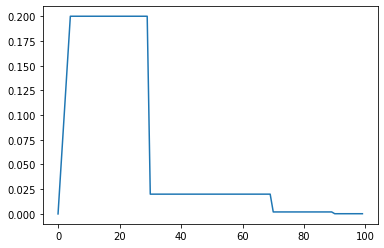

In [4]:
import matplotlib.pyplot as plt

plt.plot(lrs)
# plt.plot(step_lrs)
# plt.plot(combined)
# plt.plot(linear_warmup)

In [16]:
lrs[28:32]

[1.6, 1.6, 0.16000000000000003, 0.16000000000000003]

In [17]:
lrs[31]

0.16000000000000003

In [ ]:
from rigl_torch.models import get_model
from rigl_torch.datasets import get_dataloaders
from omegaconf import DictConfig
import hydra

In [ ]:
with hydra.initialize(config_path="../configs"):
    cfg = hydra.compose(config_name="config.yaml", overrides=[])
cfg

In [ ]:
def print_image_shape(module, input, output):
    print(f"Module {module._get_name()}")
    print(f"input shape: {input[0].shape} output shape: {output.shape}")
    return output